In [58]:
import os
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from numpy import log
from pandas import Series

In [59]:
ticker = 'TATAMOTORS.NS'
start_date = datetime(2015,1,1)
data = yf.download(ticker, start=start_date)

[*********************100%%**********************]  1 of 1 completed


## Pre-requisite rule in TSF
- all data are neumerials
- Date and target variable in neumerial.
- no null value. and null value imputation before forcasting.
- Arrange the data in sequencial order with timestamps or indices sorted in ascending order.


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2360 entries, 2015-01-01 to 2024-07-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2360 non-null   float64
 1   High       2360 non-null   float64
 2   Low        2360 non-null   float64
 3   Close      2360 non-null   float64
 4   Adj Close  2360 non-null   float64
 5   Volume     2360 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 129.1 KB


In [61]:
data.duplicated().sum()

0

In [62]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Durbin–Watson
- The Durbin-Watson statisticlies in the range 0-4. A value of 2 or nearly 2 indicates that there is no first-order autocorrelation. An acceptable range is 1.50 - 2.50. Where successive error differences are small, Durbin-Watson is low (less than 1.50); this indicates the presence of positive autocorrelation.

In [63]:
import statsmodels.api as sm

for col in data.columns:
    print(f"{col}:\t {sm.stats.durbin_watson(data[col])}")

Open:	 0.0004383746039524202
High:	 0.0003638613113485782
Low:	 0.0004349931935008423
Close:	 0.00044820106227740845
Adj Close:	 0.000447915663954024
Volume:	 0.2703787181055807


In [64]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2.360000e+03
mean,397.238448,402.376259,391.144050,396.497770,394.326739,2.379737e+07
std,202.882523,204.473533,200.653356,202.655719,202.118376,3.053309e+07
min,66.500000,66.900002,63.500000,65.300003,64.896851,9.445510e+05
25%,258.500000,261.700012,252.537502,258.175003,256.581047,7.344604e+06
50%,404.649994,409.899994,398.175003,403.774994,401.200897,1.242867e+07
75%,481.849991,488.025002,474.899994,481.525002,478.493752,2.733611e+07
max,1111.949951,1120.500000,1083.599976,1118.300049,1118.300049,3.905778e+08


## Decomposition analysis

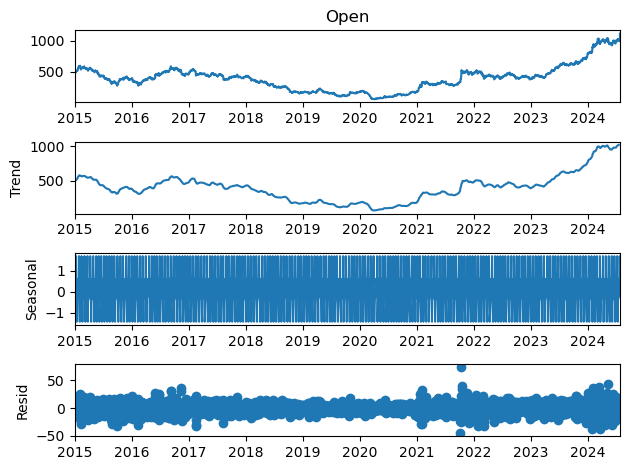

In [65]:
# Decomposition to check dataset
from statsmodels.tsa.seasonal import seasonal_decompose

decmpose = seasonal_decompose(x=data['Open'], period= 12)
decmpose.plot()
plt.show()

## box plot for 'Open' with respect to different years.

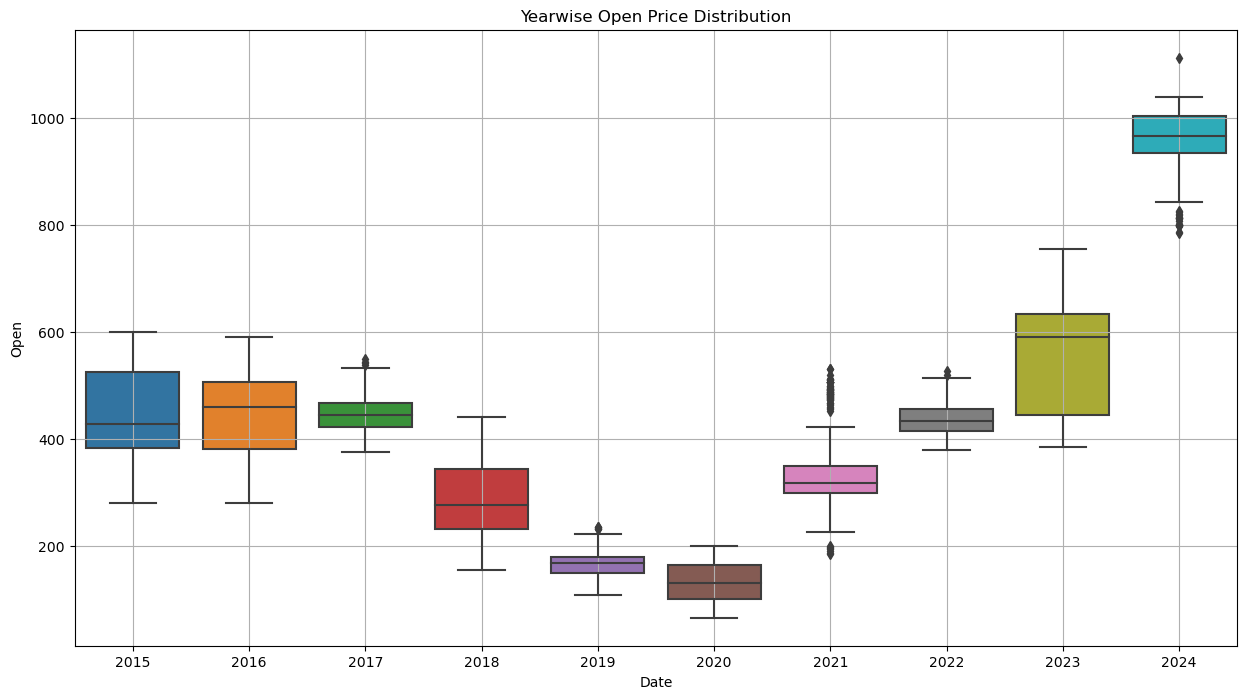

In [66]:
plt.figure(figsize=(15,8))
sns.boxplot(x=data.index.year, y=data.Open)
plt.title('Yearwise Open Price Distribution')
plt.grid()

### Observations
- 2017, 2021, 2024 are more volatile due to outliers.

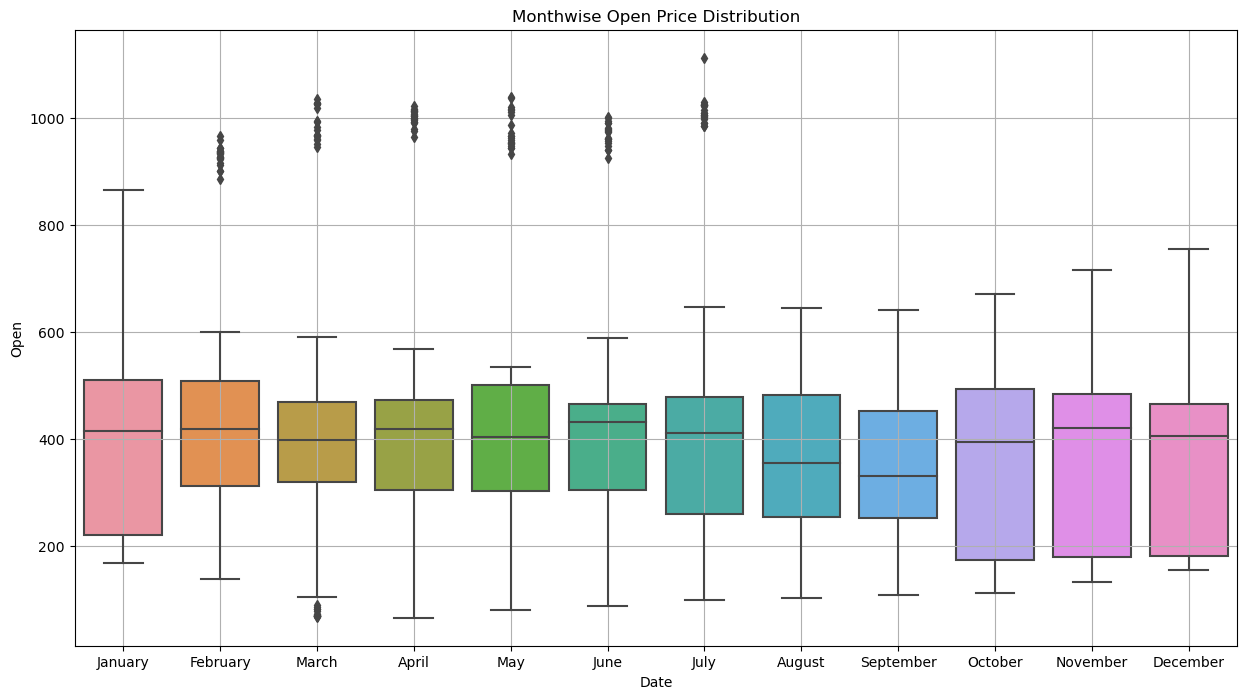

In [67]:
plt.figure(figsize=(15,8))
sns.boxplot(x=data.index.month_name(), y=data.Open)
plt.title('Monthwise Open Price Distribution')
plt.grid()

- Most profitable month fr bying is Augus.

## Checking data if it is stationary and non-stationary

### Augmented decay fuller test
-- Augmented Dickey-Fuller test (ADF Test) and Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test), which are the most common statistical tests used to test whether a given Time series is stationary or not

- Null Hypothesis(H0): data is non stationary.
- Alternate Hypothesis(Ha): data is stationary.

In [68]:
from statsmodels.tsa.stattools import  adfuller
def check_adfuller(timeseries):
    result = adfuller(timeseries)
    print("Augmented decay fuller test")
    labels = ['ADF Stats', 'P Value', 'Lags', 'No. of Observation']
    for i, j in zip(result, labels):
        print(j + ":->" + str(i))
    
    if result[1] < 0.05:
        print("Strong evidence against null hypothesis and my timeseries is stationary")
    
    else:
        print("Week Evidence against null hypothesis and timeseries is non-stationary")

In [69]:
data['1st Diff'] = data['Open'] - data['Open'].shift(1)

In [70]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,1st Diff
Date,,,,,,,
2015-01-01,489.252289,494.149750,487.026154,493.160370,489.917236,944551,NaN
2015-01-02,491.973083,511.909271,491.973083,506.368683,503.038696,4193093,2.720795
2015-01-05,504.686737,520.417969,501.322815,518.241333,514.833313,6758676,12.713654
2015-01-06,508.891632,508.891632,493.951874,496.079071,492.816742,7979598,4.204895
2015-01-07,489.746979,495.089661,484.008514,488.609192,485.395996,9232656,-19.144653


## Train Test Spliting

In [71]:
start_date = data.index.min()
end_date = data.index.max()
print("Start Date: ", start_date)
print("End Date: ", end_date)

Start Date:  2015-01-01 00:00:00
End Date:  2024-07-26 00:00:00


In [72]:
train = data[data.index < pd.to_datetime('2022-02-02')]
test = data[data.index >= pd.to_datetime('2022-02-02')]

In [73]:
train.shape, test.shape

((1749, 7), (611, 7))

In [74]:
train = train[['1st Diff']]
test = test[['1st Diff']]

In [77]:
#checking whole data for Open
check_adfuller(data['Open'].dropna())

Augmented decay fuller test
ADF Stats:->1.617992712802636
P Value:->0.9979105641775866
Lags:->0
No. of Observation:->2359
Week Evidence against null hypothesis and timeseries is non-stationary


In [78]:
check_adfuller(train['1st Diff'].dropna())

Augmented decay fuller test
ADF Stats:->-10.840199450873227
P Value:->1.623271885923645e-19
Lags:->11
No. of Observation:->1736
Strong evidence against null hypothesis and my timeseries is stationary


In [79]:
check_adfuller(test['1st Diff'])

Augmented decay fuller test
ADF Stats:->-23.600704052699225
P Value:->0.0
Lags:->0
No. of Observation:->610
Strong evidence against null hypothesis and my timeseries is stationary


In [81]:
train.dropna(inplace = True)